# Effect of Sampling Rate on Localization Estimation
This notebook is simulating the effects of sampling rate on the localization esimtation based on interesecting spheres. A sampling rate of 100 Mhz (USRP max fs) resticts range differnce measruements to be multiples of 3 meters. This notebook performs a 3d localization simulation and visualization for a single run. Then 10,000 runs are performed and some histograms are plotted to show how sampling reduces the accuaracy of the estimations.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import proj3d
from scipy.spatial import ConvexHull
from scipy.optimize import least_squares

## Plotting functions
All of the functions below are just for plotting and making a good visualization. It looks like a lot, but most of these functions were actually generated with chatGPT, and we really dont care about there performance or anything. You dont really need to read any of the code here, just look at each function as a black box. 

In [12]:
def plot_3d_points(ax, points, col='b', mark='o'):
    # Extract x, y, and z coordinates of the points
    x = points[:,0] #column0
    y = points[:,1] 
    z = points[:,2]
    # Create a 3D scatter plot of the points
    ax.scatter(x, y, z, c=col, marker=mark)

def draw_lines_on_axis(ax, single_point, points_matrix, axis='z'):
    # Get the index of the specified axis
    axis_idx = ['x', 'y', 'z'].index(axis)
    # Create a Line3D object for each point in the matrix
    for point in points_matrix:
        # Extract the x, y, and z coordinates of the point
        x, y, z = point
        # Create a line between the single point and the current point
        line = Line3D([single_point[0,axis_idx], x], 
                      [single_point[0,(axis_idx+1)%3], y], 
                      [single_point[0,(axis_idx+2)%3], z],
                      alpha=0.5)
        # Add the line to the plot
        ax.add_artist(line)
    # Set the axis labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    # Set the limits of the axis to include all points
    points = np.vstack([single_point, points_matrix])
    ax.set_xlim(points[:,0].min(), points[:,0].max())
    ax.set_ylim(points[:,1].min(), points[:,1].max())
    ax.set_zlim(points[:,2].min(), points[:,2].max())

def draw_line_between_points(ax, point1, point2):
    # Create a Line3D object between the two points
    line = Line3D([point1[0,0], point2[0,0]],
                  [point1[0,1], point2[0,1]],
                  [point1[0,2], point2[0,2]],
                  color='k', linestyle='--', alpha=0.5, linewidth=1)
    # Add the line to the plot
    ax.add_artist(line)
    

def add_distance_label(ax, point1, point2):
    x1, y1, z1 = point1.T
    x2, y2, z2 = point2.T
    # Find midpoint between the two points
    mid_x = int((x1 + x2) / 2)
    mid_y = int((y1 + y2) / 2)
    mid_z = int((z1 + z2) / 2)
    midpoint = [mid_x, mid_y, mid_z]
    # Calculate distance between the two points
    distance = np.linalg.norm(point1 - point2)
    # Add text label at midpoint with distance
    d_str = 'RD={:.2f}'.format(distance)
    label =ax.text(mid_x, mid_y, mid_z, d_str, fontsize=8, ha='center', va='bottom', color='blue')
    label.set_zorder(1000)


def draw_lines_to_points(axis, start_point, end_points, add_label=True):
    for end_point in end_points:
        end = end_point.reshape(1,3)
        draw_line_between_points(axis, start_point, end)
        if add_label:
            add_distance_label(ax, start_point, end)

def draw_sphere(ax, source_point, radius, alpha=0.2, color='blue'):
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = source_point[0] + radius*np.cos(u)*np.sin(v)
    y = source_point[1] + radius*np.sin(u)*np.sin(v)
    z = source_point[2] + radius*np.cos(v)
    sphere = Poly3DCollection([list(zip(x[:,i], y[:,i], z[:,i])) for i in range(z.shape[1])], alpha=alpha, color=color)
    ax.add_collection3d(sphere)

## Math Funcitons
The funcitons in this cell are used for the actual localization math. Only the  `calculate_distance()` and `sphere_intersection_trf()` functions acually get used throughout the rest of the notebook. The other two sphere intersection functions were failed attempts, but I am just leaving them here for now. 

In [13]:
def calculate_distances(source_point, rx_points):
    return np.linalg.norm(rx_points - source_point, axis=1)

def sphere_intersection(center_points, radiuses):
    # make sure there are exactly 4 center points and radiuses
    if len(center_points) != 4 or len(radiuses) != 4:
        raise ValueError("Exactly four center points and radiuses are required.")
    
    # solve the system of equations
    A = np.zeros((4, 4))
    B = np.zeros((4, 1))
    for i in range(4):
        A[i, :] = 2 * (center_points[i, :] - center_points[0, :])
        B[i] = np.sum(center_points[i, :]**2) - np.sum(center_points[0, :]**2) + radiuses[0]**2 - radiuses[i]**2
    x, y, z = np.linalg.solve(A, B).flatten()
    # return the intersection point
    return np.array([x, y, z])


def sphere_intersection_lm(center_points, radiuses):
    # make sure there are at least two center points and radiuses
    if len(center_points) < 2 or len(radiuses) < 2:
        raise ValueError("At least two center points and radiuses are required.")

    # define the residual function
    def residual_function(x, center_points, radiuses):
        return np.sum((np.linalg.norm(center_points - x, axis=1) - radiuses)**2)

    # initialize the initial guess and run the Levenberg-Marquardt algorithm
    x0 = center_points.mean(axis=0)
    result = least_squares(residual_function, x0, args=(center_points, radiuses), method='lm')

    # return the intersection point
    return result.x

#this method seems to work the most accurately
#read up on the Trus Region Refletive algorithm to see if it can be implemented in C++
def sphere_intersection_trf(center_points, radiuses):
    # make sure there are at least two center points and radiuses
    if len(center_points) < 2 or len(radiuses) < 2:
        raise ValueError("At least two center points and radiuses are required.")
    
    # define the residual function
    def residual_function(x, center_points, radiuses):
        return np.sum((np.linalg.norm(center_points - x, axis=1) - radiuses)**2)
    
    # set the initial guess as the centroid of the center points
    initial_guess = np.mean(center_points, axis=0)
    
    # solve the optimization problem using the 'trf' method
    result = least_squares(residual_function, initial_guess, args=(center_points, radiuses), method='trf')
    
    # return the intersection point
    return result.x

## Visualization
The code here generates a random position for the trransmitter, then estimates the transmitter positon based on the range differences, and generates a nice 3D visualization of the estimation. You can try running this cell a few times to see the plot update. 

true tx pos=[64.46016897 17.52656139 98.99980401]
est  tx pos=[65.32388149 16.78152369 99.51832589]
error=1.25


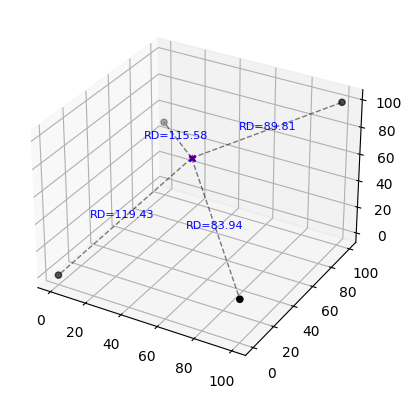

In [14]:
# Create a Numpy array with random 3D points
rxpoints = np.array([[0,0,0], [100,0,25], [0,100,50], [100,100,100]])
txpoint = np.random.uniform(0,100, size=(1,3))

range_diffs_exact = calculate_distances(txpoint, rxpoints)
range_diffs = np.round(range_diffs_exact / 3) *3
toas_exact = range_diffs / 3e8

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D points
plot_3d_points(ax,rxpoints, 'k')
plot_3d_points(ax,txpoint, 'r', '*')

#draw lines
draw_lines_to_points(ax, txpoint, rxpoints)

intersection = sphere_intersection_trf(rxpoints, range_diffs)
intersection = intersection.reshape(3,1)
plot_3d_points(ax, intersection.T, 'b', 'x')

txpoint = txpoint.reshape(3,)
intersection = intersection.reshape(3,)
error = np.linalg.norm(txpoint-intersection)

err_label = 'true tx pos={}\nest  tx pos={}\nerror={:.2f}'.format(txpoint, intersection, error)
#ax.text(0,0,50, err_label, fontsize=8)
print(err_label)

# Monte Carlo Sim
Finally I ran 10,000 simualitons generating a new random transmitter location each time then estimating the position with and without the 3 meter range differnce rounding. I plotted some histograms that show how  sampling makes the position estimate less accurate. 

The last two histograms are the most insightful. I added a theshold ot remove data that had an error of more then 10 meters and replotted the histograms so we could better see the distribution for the majority of the data points. I also made sure to count the number of data points we threw away and print that value too. 

We can see that the errors without sampling are almost all less ht

In [6]:
N = 10000
range_resolution = 3 #3 meter range resolution based on USRP 100Mhz sampling rate (see ./docs/dsp/sample_rate_notes.md)
rxpoints = np.array([[0,0,0], [100,0,25], [0,100,50], [100,100,100]])

errors_no_sampling = np.zeros(N)
errors_with_sampling = np.zeros(N)

for i in range(N):
    txpoint = np.random.uniform(0,100, size=(1,3))
    
    range_diffs_exact = calculate_distances(txpoint, rxpoints)
    range_diffs = np.round(range_diffs_exact / range_resolution) * range_resolution #round to the neares multiple of the range resoltuon
    
    intersection_exact = sphere_intersection_trf(rxpoints, range_diffs_exact)
    intersection = sphere_intersection_trf(rxpoints, range_diffs)
    
    txpoint = txpoint.reshape(3,)
    intersection_exact = intersection_exact.reshape(3,)
    intersection = intersection.reshape(3,)
    
    errors_no_sampling[i] = np.linalg.norm(txpoint-intersection_exact)
    errors_with_sampling[i] = np.linalg.norm(txpoint-intersection)

def remove_above_threshold(arr, threshold):
    num_above_threshold = np.sum(arr > threshold)
    arr = arr[arr <= threshold]
    return arr, num_above_threshold

threshold = 10 #meters
err3, count3 = remove_above_threshold(errors_no_sampling, threshold)
err4, count4 = remove_above_threshold(errors_with_sampling, threshold)


(array([8.667e+03, 2.700e+01, 5.100e+01, 8.100e+01, 9.700e+01, 9.300e+01,
        8.900e+01, 9.500e+01, 7.600e+01, 1.010e+02, 9.100e+01, 8.000e+01,
        7.300e+01, 7.300e+01, 5.300e+01, 5.700e+01, 4.100e+01, 3.900e+01,
        3.200e+01, 2.500e+01, 2.300e+01, 1.500e+01, 7.000e+00, 6.000e+00,
        8.000e+00]),
 array([3.42297668e-05, 5.00300407e+00, 1.00059739e+01, 1.50089438e+01,
        2.00119136e+01, 2.50148834e+01, 3.00178533e+01, 3.50208231e+01,
        4.00237930e+01, 4.50267628e+01, 5.00297327e+01, 5.50327025e+01,
        6.00356723e+01, 6.50386422e+01, 7.00416120e+01, 7.50445819e+01,
        8.00475517e+01, 8.50505216e+01, 9.00534914e+01, 9.50564612e+01,
        1.00059431e+02, 1.05062401e+02, 1.10065371e+02, 1.15068341e+02,
        1.20071310e+02, 1.25074280e+02]),
 <BarContainer object of 25 artists>)

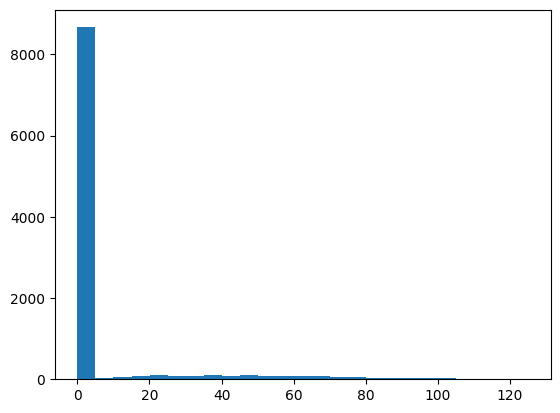

In [7]:
n_bins = 25
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(errors_no_sampling, n_bins)

(array([7.802e+03, 5.820e+02, 1.760e+02, 1.370e+02, 1.210e+02, 1.220e+02,
        1.090e+02, 1.030e+02, 1.060e+02, 1.030e+02, 8.800e+01, 8.000e+01,
        8.700e+01, 7.400e+01, 5.100e+01, 6.100e+01, 4.200e+01, 4.300e+01,
        3.800e+01, 2.900e+01, 2.100e+01, 1.400e+01, 4.000e+00, 4.000e+00,
        3.000e+00]),
 array([8.84815065e-02, 5.15138410e+00, 1.02142867e+01, 1.52771893e+01,
        2.03400919e+01, 2.54029945e+01, 3.04658971e+01, 3.55287997e+01,
        4.05917023e+01, 4.56546049e+01, 5.07175075e+01, 5.57804100e+01,
        6.08433126e+01, 6.59062152e+01, 7.09691178e+01, 7.60320204e+01,
        8.10949230e+01, 8.61578256e+01, 9.12207282e+01, 9.62836308e+01,
        1.01346533e+02, 1.06409436e+02, 1.11472339e+02, 1.16535241e+02,
        1.21598144e+02, 1.26661046e+02]),
 <BarContainer object of 25 artists>)

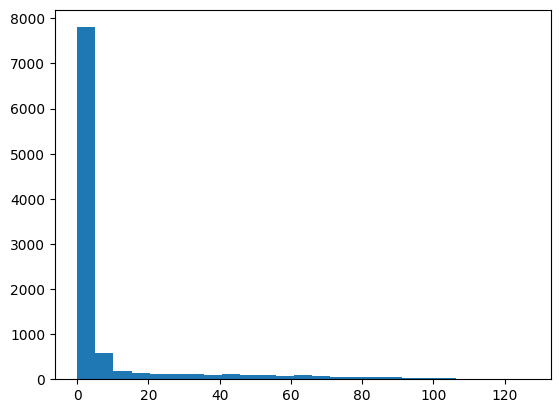

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(errors_with_sampling, n_bins)

1306


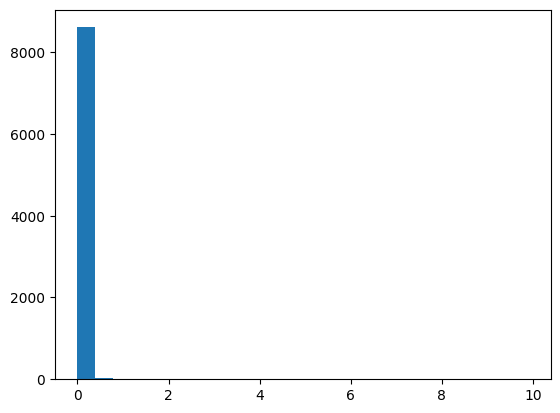

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(err3, n_bins)
print(count3)

1632


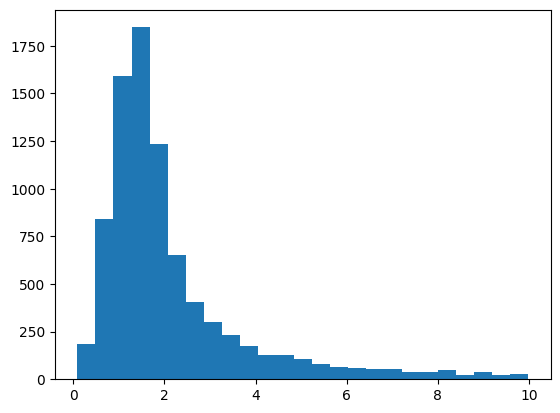

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(err4, n_bins)
print(count4)

## Bonus C code
I used chatGPT to write a C function to mimc the `sphere_intersection_trf()` function I used in the python simulaitons. I highly doubt this code will actually work, but its a potentially goo starting point when trying to implement localization in C rather then python. 

In [11]:
#include <stdio.h>
#include <gsl/gsl_multimin.h>

typedef struct {
    int n;                // number of spheres
    double (*center)[3];  // center points of spheres
    double *radius;       // radiuses of spheres
} sphere_data;

double sphere_func(const gsl_vector *x, void *params)
{
    sphere_data *data = (sphere_data *) params;
    double sum = 0.0;
    for (int i = 0; i < data->n; i++) {
        double dx = gsl_vector_get(x, 0) - data->center[i][0];
        double dy = gsl_vector_get(x, 1) - data->center[i][1];
        double dz = gsl_vector_get(x, 2) - data->center[i][2];
        sum += (dx*dx + dy*dy + dz*dz - data->radius[i]*data->radius[i]) * (dx*dx + dy*dy + dz*dz - data->radius[i]*data->radius[i]);
    }
    return sum;
}

void sphere_gradient(const gsl_vector *x, void *params, gsl_vector *g)
{
    sphere_data *data = (sphere_data *) params;
    double sum_x = 0.0;
    double sum_y = 0.0;
    double sum_z = 0.0;
    for (int i = 0; i < data->n; i++) {
        double dx = gsl_vector_get(x, 0) - data->center[i][0];
        double dy = gsl_vector_get(x, 1) - data->center[i][1];
        double dz = gsl_vector_get(x, 2) - data->center[i][2];
        double factor = 2.0 * (dx*dx + dy*dy + dz*dz - data->radius[i]*data->radius[i]);
        sum_x += factor * dx;
        sum_y += factor * dy;
        sum_z += factor * dz;
    }
    gsl_vector_set(g, 0, sum_x);
    gsl_vector_set(g, 1, sum_y);
    gsl_vector_set(g, 2, sum_z);
}

void sphere_fdf(const gsl_vector *x, void *params, double *f, gsl_vector *g)
{
    *f = sphere_func(x, params);
    sphere_gradient(x, params, g);
}

void sphere_intersection(int n, double (*center)[3], double *radius, double *x)
{
    gsl_multimin_function_fdf sphere;
    sphere.n = 3;
    sphere.f = &sphere_func;
    sphere.df = &sphere_gradient;
    sphere.fdf = &sphere_fdf;
    sphere.params = (void *) &((sphere_data) {n, center, radius});

    const gsl_multimin_fdfminimizer_type *T;
    gsl_multimin_fdfminimizer *minimizer;
    T = gsl_multimin_fdfminimizer_truncated_newton;
    minimizer = gsl_multimin_fdfminimizer_alloc(T, 3);
    gsl_vector *start = gsl_vector_alloc(3);
    gsl_vector_set(start, 0, 0.0);
    gsl_vector_set(start, 1, 0.0);
    gsl_vector_set(start, 2, 0.0);
    gsl_multimin_fdfminimizer_set(minimizer, &sphere, start, 0.1, 1e-6);

    int status;
    int iter = 0

SyntaxError: invalid syntax (3917430274.py, line 4)